In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo


np.set_printoptions(threshold=np.inf)

In [2]:
system="BlackP"
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/"+system+"/"

In [3]:
nkx=48
nky=48
nkz=48


name_Exciton_energy = str(nkx)+'x'+str(nky)+'x'+str(nkz)+'.log'

result = subprocess.run(['bash','./log_Hqpgw_new/read.sh', './log_Hqpgw_new/'+name_Exciton_energy, 'E(1)', "1"],capture_output=True,text=True)
E_exciton = float(result.stdout.strip())

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_wann_calc.h5"
Energies = Reading.ReadBands(fname)
#Energie_Valence = np.reshape(Energies[:,19],[nkx,nky,nkz])
Energie_no_Valence  = Energies[:,18]
Energie_Valence     = Energies[:,19]
Energie_Conduction  = Energies[:,20]



##estos archivos se deben mover a la carpeta de outputs al final del dia
fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc.h5"
ϵ,ϕ_real,ϕ_imag =Reading.Read_Eigen_states(fname)

fname="./out_Hqpgw_new/"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_exc_dens.h5"

ψ = Reading.Read_Density(fname)


fname_new="./../../OUT/Band_Structure_out/"+system+"_New_Ham"+"_wann_calc.h5"


epsk_new=Reading.ReadBands(fname_new)
print(27.2*(np.min(Energie_Conduction)-np.max(Energie_Valence)))

0.5062111888334536


In [42]:
first_x   = np.arange(0,int(nkx/2)+1,1,dtype=int)
second_x  = np.arange(-int(nkx/2)+1,0,1,dtype=int)

first_y   = np.arange(0,int(nky/2)+1,1,dtype=int)
second_y  = np.arange(-int(nky/2)+1,0,1,dtype=int)

first_z   = np.arange(0,int(nkz/2)+1,1,dtype=int)
second_z  = np.arange(-int(nkz/2)+1,0,1,dtype=int)

total_x = np.array( list(first_x) + list(second_x))
total_y = np.array( list(first_y) + list(second_y))
total_z = np.array( list(first_z) + list(second_z))

irvec = np.zeros( (len(total_x)*len(total_y)*len(total_z),3),dtype=int )

"""X, Y, Z = np.meshgrid(total_x, total_y, total_z, indexing='ij')
#X, Y, Z = np.meshgrid(total_x, total_y, total_z)
irvec[:,0] = np.reshape(X, [nkx*nky*nkz])
irvec[:,1] = np.reshape(Y, [nkx*nky*nkz])
irvec[:,2] = np.reshape(Z, [nkx*nky*nkz])
"""
contador=0
for kk in range(0,len(total_z)):
    for jj in range(0,len(total_y)):
        for ii in range(0,len(total_x)):

            irvec[contador,0] = total_x[ii]
            irvec[contador,1] = total_y[jj]
            irvec[contador,2] = total_z[kk]
            contador+=1

xs = irvec[:,0]
ys = irvec[:,1]
zs = irvec[:,2]


#===========================================================================
def K_PATH(k_points_path,n_kpts):
    new_path = np.zeros((3,(np.shape(k_points_path)[0]-1)*n_kpts))

    for i in range(np.shape(k_points_path)[0]-1):
        eje_x = np.linspace(k_points_path[i,0],k_points_path[i+1,0],n_kpts+1)[0:-1]
        eje_y = np.linspace(k_points_path[i,1],k_points_path[i+1,1],n_kpts+1)[0:-1]
        eje_z = np.linspace(k_points_path[i,2],k_points_path[i+1,2],n_kpts+1)[0:-1]

        new_path[0,i*n_kpts:(i+1)*n_kpts] = eje_x
        new_path[1,i*n_kpts:(i+1)*n_kpts] = eje_y
        new_path[2,i*n_kpts:(i+1)*n_kpts] = eje_z
        
    return new_path

def Delta (E,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*E**2/sigma**2)

def SHIFTING_KplusP(nk1,nk2,nk3,Ψ_k,pexc):
    Ψ = np.reshape(Ψ_k, [nk1,nk2,nk3])
    
    Ψ_r = np.fft.fftn(Ψ)

    xr = np.fft.fftfreq(nk1,d=1. / nk1).astype(int)
    yr = np.fft.fftfreq(nk2,d=1. / nk2).astype(int)
    zr = np.fft.fftfreq(nk3,d=1. / nk3).astype(int)

    ex1 = np.exp(-2.0j*np.pi*xr*(pexc[0]))
    ex2 = np.exp(-2.0j*np.pi*yr*(pexc[1]))
    ex3 = np.exp(-2.0j*np.pi*zr*(pexc[2]))

    Ψ_r_p = np.einsum('i,j,k,ijk->ijk', ex1, ex2,ex3, Ψ_r)

    Ψ_k_p = np.fft.ifftn(Ψ_r_p)
    
    return Ψ_k_p

def FourierInterpolate(nk1,nk2,nk3,Ψ_k_p,kpts):
    # x = np.reshape(vect[ist,:], [nk1,nk2])
    Ψ = np.reshape(Ψ_k_p, [nk1,nk2,nk3])
    Ψ_r = np.fft.fftn(Ψ)

    xr = np.fft.fftfreq(nk1,d=1. / nk1).astype(int)
    yr = np.fft.fftfreq(nk2,d=1. / nk2).astype(int)
    zr = np.fft.fftfreq(nk3,d=1. / nk3).astype(int)

    nk = kpts.shape[1]
    
    vect_int = np.zeros(nk,dtype=np.complex_)
    
    for ik in range(nk):
        kpt = kpts[:,ik]

        ex1 = np.exp(2j*np.pi*xr*(kpt[0]+0.5))
        ex2 = np.exp(2j*np.pi*yr*(kpt[1]+0.5))
        ex3 = np.exp(2j*np.pi*zr*(kpt[2]+0.5))

        
        vect_int[ik] = np.einsum('i,j,k,ijk', ex1, ex2,ex3, Ψ_r) / (nk1 * nk2 * nk3)**(2)
    
    return vect_int


#===========================================================================

In [4]:
p_ex = np.array([.0,.0,.0])

Ψ_k_p   = Photo.SHIFTING_KplusP(nkx,nky,nkz,ψ[0,:],p_ex)
Ec_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,p_ex)
Ev_k_p  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,p_ex)
Env_k_p = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,p_ex)

print(27.2*(np.min(Ec_k_p)-np.max(Ev_k_p)))

EnergySpectrum = np.linspace(np.min(Energie_Valence)+ϵ[0]-0.01,np.max(Energie_Valence)+ϵ[0]+0.015,600)

tolerancia = 0.005

(0.5062111888334546+2.3087949060351654e-17j)


In [46]:
#===========================================================================
k_points_path = np.array([[0.0,0.0,0.0],[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.5]])
n_kpts=80
new_path = kgrid.K_PATH(k_points_path,n_kpts)
klabel=[r"$\Gamma$","X","S","Y",r"$\Gamma$","X"]

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,new_path)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,new_path)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,new_path)

print(27.2*(np.min(Ec_kpts)-np.max(Ev_kpts)))

Intensity = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
            Intensity[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])


np.shape(new_path)

(0.5062111888334533+2.7302939247280827e-17j)


(400, 3)

In [5]:
nk1=60
nk2=60
nk3=8
delta = 0.1
x_kpts = np.linspace(0-delta,0+delta,nk1)
y_kpts = np.linspace(0-delta,0+delta,nk2)


k_grid = kgrid.GenKgrid(nk1,nk2,nk3,delta,path)

Ψ_kpts   = Photo.FourierInterpolate(nkx,nky,nkz,Ψ_k_p,k_grid)
Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_p,k_grid)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,k_grid)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_p,k_grid)

print(27.2*(np.min(Ec_kpts)-np.max(Ev_kpts)))

Intensity_E  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_C  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_V  = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)
Intensity_nV = np.zeros((len(EnergySpectrum),np.shape(Ψ_kpts)[-1]),dtype=np.complex_)

for ω_ii in range(len(EnergySpectrum)):

    for kk in range(np.shape(Ev_kpts)[-1]):
        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0])<= tolerancia:
            Intensity_E[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk]-ϵ[0], tolerancia) * np.real(Ψ_kpts[kk])

        if abs(EnergySpectrum[ω_ii]-Ev_kpts[kk])<= tolerancia:
            Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])
            
        if abs(EnergySpectrum[ω_ii]-Env_kpts[kk])<= tolerancia:
            Intensity_nV[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Env_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])
        
        if abs(EnergySpectrum[ω_ii]-Ec_kpts[kk])<= tolerancia:
            Intensity_C[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia) #* np.real(Ψ_kpts[kk])


(0.5266788255296444+0.00023233555103420296j)


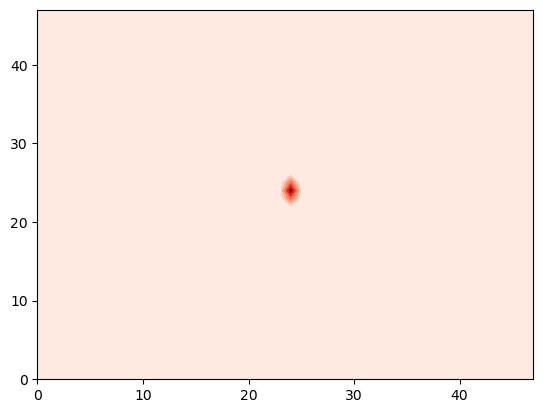

In [171]:
fig, ax = plt.subplots(1, 1)
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
#levels = np.arange(0.0,0.6, 0.01)
#levels[0] = 1e-3
#norm = colors.BoundaryNorm(levels, ncolors=palette.N)


#contour = ax.imshow(ψ[0,:].reshape(32,32,32)[:,:,16],aspect='auto', cmap=palette,norm=norm)
contour = ax.contourf(np.real(Ψ_k_p[:,:,int(nkz/2)]), cmap=palette)
#cbar = fig.colorbar(contour, extend='min', shrink=0.9, ax=ax)

/home/juanmosquera/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_3804/851554400.py:51: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


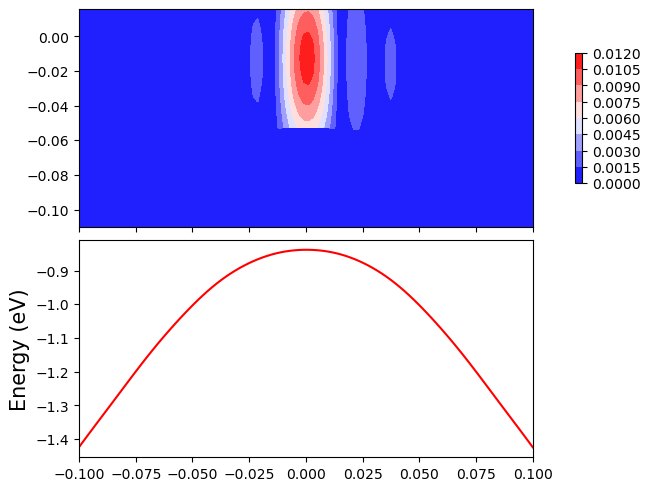

In [7]:
x_kpts = np.linspace(0-delta,0+delta,nk1)
y_kpts = np.linspace(0-delta,0+delta,nk2)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,layout='constrained')

#Intensity_plot = Intensity.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
Intensity_plot = Intensity_E.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]


nk = epsk_new.shape[0]


palette = copy(plt.get_cmap('bwr'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
levels = np.arange(2,12, 0.1)
#levels[0] = 1e-2
#levels[0] = -2.0001
norm = colors.BoundaryNorm(levels, ncolors=palette.N)

#contour = ax1.contourf(x_kpts,EnergySpectrum,np.real(Intensity[:,:]),norm=norm,cmap=palette)
contour = ax1.contourf(x_kpts,EnergySpectrum,np.abs(Intensity_plot),cmap="bwr")
fig.colorbar(contour, ax=ax1, shrink=0.6)
#ax1.set_ylim(-0.015,0.015)

#plt.colorbar(contour)

"""for ibnd in range(nbnd):
        
    ax2.plot(xk, cst.Ry * epsk_new[:,ibnd],'--', c='gray')"""



ax2.plot(x_kpts, cst.Ry * E_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),0], c='red')
#ax2.plot(x_kpts, cst.Ry * E_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,0], c='red')
#ax2.set_xlim(0.0,1.0)

#ax2.set_ylim(-3.5,0.0)
ax2.set_ylabel(r'Energy (eV)',fontsize=15)

"""knode = np.linspace(0,1,len(klabel))
for i in range(1,len(klabel)-1):
    ax2.axvline(x=knode[i],c='k', ls='--')

ax2.set_xticks(knode)
ax2.set_xticklabels(klabel,fontsize=15)
ax2.tick_params(axis='y', labelsize=15)
"""
#ax1.set_xlim(0.6,1.0)

plt.subplots_adjust(hspace=0)

#plt.plot(E_kpts)
##plt.contourf(E_kpts.reshape(nk1,nk2,nk3)[:,:,0]*27.2)
##plt.colorbar()
#plt.plot(x,E_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),0]*27.2)
#plt.plot(y,E_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,0]*27.2)



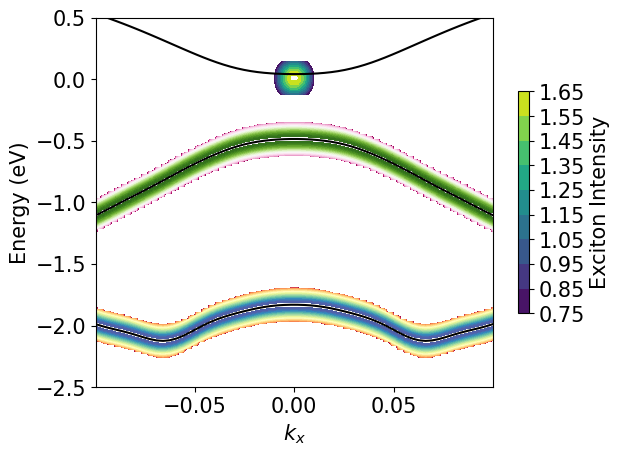

In [37]:
IntensityE_plot  = Intensity_E.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]
IntensityC_plot  = Intensity_C.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]
IntensityV_plot  = Intensity_V.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]
IntensitynV_plot = Intensity_nV.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,:,int(nk2/2),int(nk3/2)]

fig, ax1 = plt.subplots()

cbarticks = np.arange(40.0,np.max(np.abs(IntensityV_plot)),1)
cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#


a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityV_plot)) ,cmap="PiYG")
b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)

#fig.colorbar(a, ax=ax1, shrink=0.6)
cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
cbar.ax.tick_params(labelsize=15)

ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * Env_kpts.reshape(nk1,nk2,nk3)[:,int(nk2/2),int(nk3/2)], c='black')

ax1.set_ylim(-2.5,0.5)
#ax1.set_xlim(-.05,.05)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_x$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


#plt.savefig("Spectrum_X.png",bbox_inches='tight')


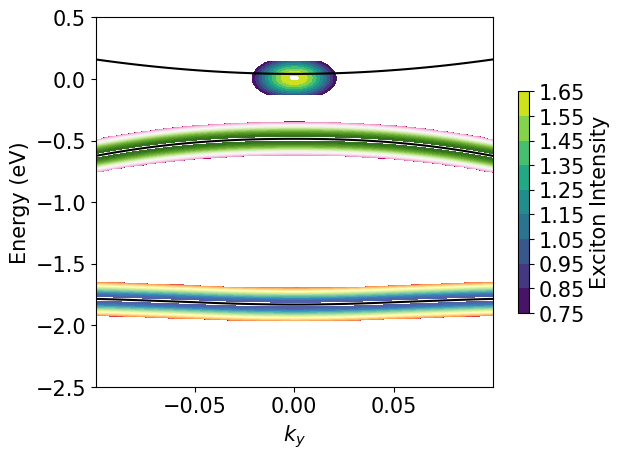

In [38]:
IntensityE_plot  = Intensity_E.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
IntensityC_plot  = Intensity_C.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
IntensityV_plot  = Intensity_V.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]
IntensitynV_plot = Intensity_nV.reshape(len(EnergySpectrum),nk1,nk2,nk3)[:,int(nk1/2),:,int(nk3/2)]

fig, ax1 = plt.subplots()

cbarticks = np.arange(40.0,np.max(np.abs(IntensityV_plot)),1)
cbarticksE = np.arange(0.75,np.max(np.abs(IntensityE_plot)),0.1)

#contour = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cmap="bwr")
#


a = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityV_plot)) ,cmap="PiYG")
b = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensitynV_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="Spectral")
#c = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityC_plot),cbarticks, vmin = 40, vmax = np.max(np.abs(IntensityC_plot)),cmap="bwr")

e = ax1.contourf(x_kpts,cst.Ry * EnergySpectrum,np.abs(IntensityE_plot),cbarticksE, vmin = 0.75, vmax = np.max(np.abs(IntensityE_plot)) )

#plt.colorbar(a, ax=ax1,ticks=cbarticks)

#fig.colorbar(a, ax=ax1, shrink=0.6)
cbar = fig.colorbar(e, ax=ax1, shrink=0.6)
cbar.ax.set_ylabel('Exciton Intensity', rotation=90,fontsize=15)
cbar.ax.tick_params(labelsize=15)

ax1.plot(x_kpts, cst.Ry * Ec_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * Ev_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)], c='black')
ax1.plot(x_kpts, cst.Ry * Env_kpts.reshape(nk1,nk2,nk3)[int(nk1/2),:,int(nk3/2)], c='black')

ax1.set_ylim(-2.5,0.5)
#ax1.set_xlim(-.05,.05)
ax1.set_xticks([-0.05,0.0,0.05])

ax1.set_xlabel(r"$k_y$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

#plt.savefig("Spectrum_Y.png",bbox_inches='tight')


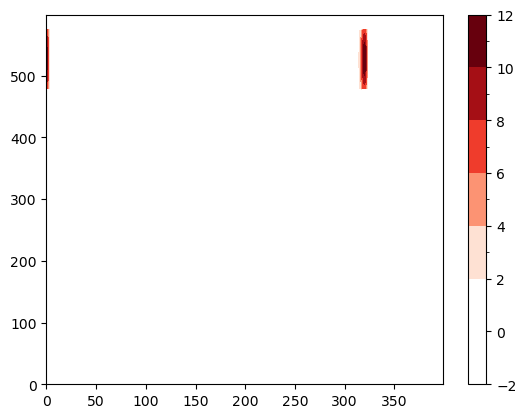

In [228]:
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
levels = np.arange(2,12, 1)
#levels[0] = 1e-2
#levels[0] = -2.0001
norm = colors.BoundaryNorm(levels, ncolors=palette.N)


contour = plt.contourf(np.real(Photo[:,:]),norm=norm,cmap=palette)
#contour = plt.contourf(x_kpts,EnergySpectrum,np.real(Photo[:,:]))

plt.colorbar(contour)

/home/juanmosquera/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_22814/3590655579.py:51: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


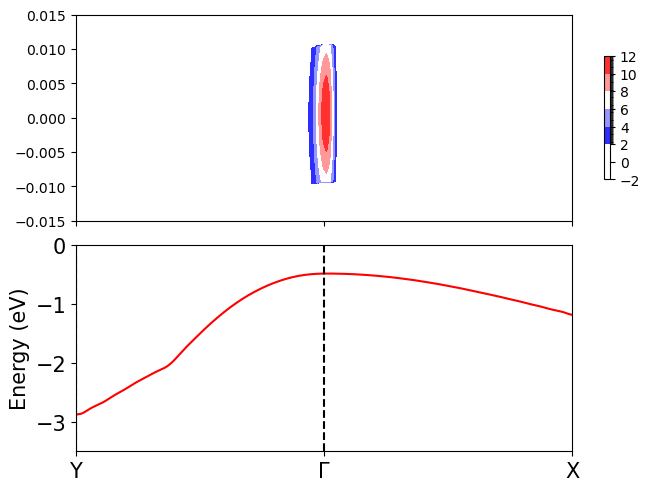

In [7]:
x_kpts = np.linspace(0.0, 1.0, (np.shape(k_points_path)[0]-1)*n_kpts)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,layout='constrained')

                              
                              


nk = epsk_new.shape[0]
nbnd = epsk_new.shape[1]
xk = np.linspace(0.0, 1.0, nk)



palette = copy(plt.get_cmap('bwr'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
levels = np.arange(2,12, 0.1)
#levels[0] = 1e-2
#levels[0] = -2.0001
norm = colors.BoundaryNorm(levels, ncolors=palette.N)

contour = ax1.contourf(x_kpts,EnergySpectrum,np.real(Intensity[:,:]),norm=norm,cmap=palette)
#contour = ax1.contourf(x_kpts,EnergySpectrum,np.real(Intensity[:,:]),cmap="bwr")
fig.colorbar(contour, ax=ax1, shrink=0.6)
#ax1.set_ylim(-0.015,0.015)

#plt.colorbar(contour)

"""for ibnd in range(nbnd):
        
    ax2.plot(xk, cst.Ry * epsk_new[:,ibnd],'--', c='gray')"""



ax2.plot(x_kpts, cst.Ry * E_kpts, c='red')
#ax2.set_xlim(0.0,1.0)

ax2.set_ylim(-3.5,0.0)
ax2.set_ylabel(r'Energy (eV)',fontsize=15)

knode = np.linspace(0,1,len(klabel))
for i in range(1,len(klabel)-1):
    ax2.axvline(x=knode[i],c='k', ls='--')

ax2.set_xticks(knode)
ax2.set_xticklabels(klabel,fontsize=15)
ax2.tick_params(axis='y', labelsize=15)

ax1.set_xlim(0.6,1.0)

plt.subplots_adjust(hspace=0)